In [149]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#### &#10140; *EDA*</br>

In [150]:
trainData = pd.read_csv('./data/train.csv')

print('Data shape: ', trainData.shape)

Data shape:  (1460, 81)


In [151]:
trainData.drop(['Id'], axis=1, inplace=True)

print(trainData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### -- `Log-Transformation` -- 

Text(0.5, 0, 'Log(SalePrice)')

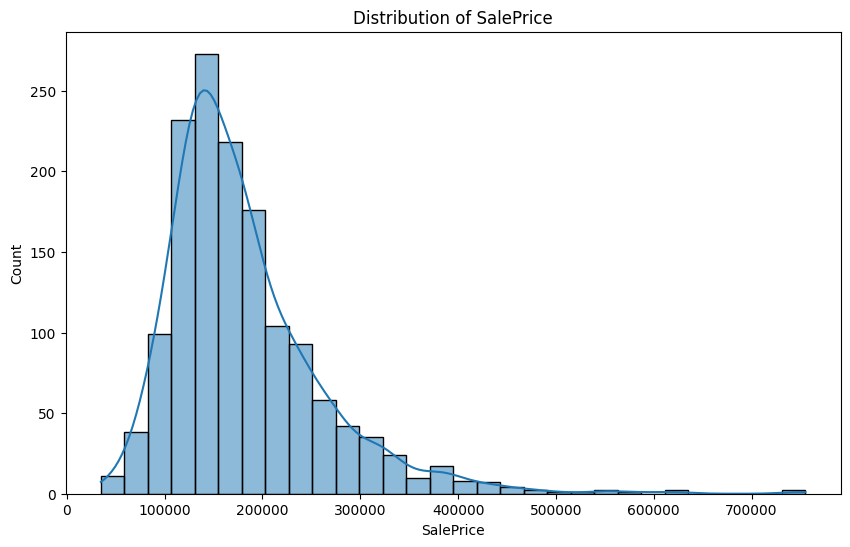

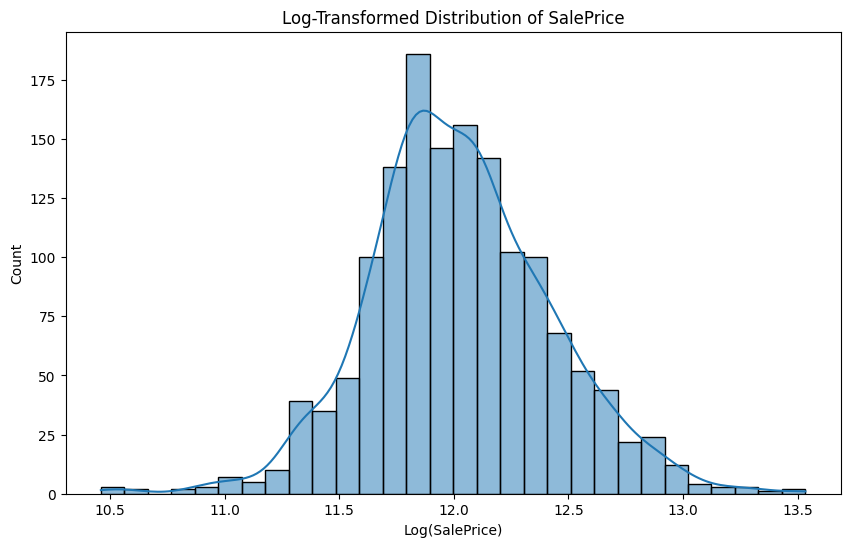

In [152]:
plt.figure(figsize=(10, 6))
sns.histplot(trainData['SalePrice'], bins=30, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')


trainData['SalePrice'] = np.log1p(trainData['SalePrice'])
plt.figure(figsize=(10, 6))
sns.histplot(trainData['SalePrice'], bins=30, kde=True)
plt.title('Log-Transformed Distribution of SalePrice')
plt.xlabel('Log(SalePrice)')

### -- `Missing Data` -- 

In [153]:
missing = trainData.isnull().sum() 
missing = missing[missing > 0].sort_values(ascending=False)

print(missing.head(20))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [154]:
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond',
            'MasVnrType']:
    trainData[col] = trainData[col].fillna("None")

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
            'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'MasVnrArea']:
    trainData[col] = trainData[col].fillna(0)

trainData["LotFrontage"] = trainData.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

trainData['Electrical'] = trainData['Electrical'].fillna(trainData['Electrical'].mode()[0])

print(trainData.isnull().sum().sort_values(ascending=False).head(10))

MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
Street         0
Alley          0
LotShape       0
LandContour    0
Utilities      0
LotConfig      0
dtype: int64


### -- `Zero Data` -- 

In [155]:
zero_value = trainData.isin([0]).sum()
zero_value = zero_value[zero_value > 0].sort_values(ascending=False)
print(zero_value.head(30))

PoolArea         1453
3SsnPorch        1436
LowQualFinSF     1434
MiscVal          1408
BsmtHalfBath     1378
ScreenPorch      1344
BsmtFinSF2       1293
EnclosedPorch    1252
HalfBath          913
MasVnrArea        869
BsmtFullBath      856
2ndFlrSF          829
WoodDeckSF        761
Fireplaces        690
OpenPorchSF       656
BsmtFinSF1        467
BsmtUnfSF         118
GarageArea         81
GarageYrBlt        81
GarageCars         81
TotalBsmtSF        37
FullBath            9
BedroomAbvGr        6
KitchenAbvGr        1
dtype: int64


In [156]:
trainData['KitchenAbvGr'] = trainData['KitchenAbvGr'].fillna(trainData['KitchenAbvGr'].mode()[0])

### -- `Categorical objects` -- 

In [157]:
cat_cols = trainData.select_dtypes(include=["object"]).columns
print(cat_cols)


cat_cols = trainData.select_dtypes(include=["object"]).columns

for col in cat_cols:
    print(f"{col}: {trainData[col].nunique()} унікальних значень")

trainData = pd.get_dummies(trainData, columns=cat_cols)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
MSZoning: 5 унікальних значень
Street: 2 унікальних значень
Alley: 3 унікальних значень
LotShape: 4 унікальних значень
LandContour: 4 унікальних значень
Utilities: 2 унікальних значень
LotConfig: 5 унікальних значень
LandSlope: 3 унікальних значень
Neighborhood: 25 унікальних значень
Condition1: 9 унікальних значень
Condition2: 8 уні

### -- `Outliers` -- 

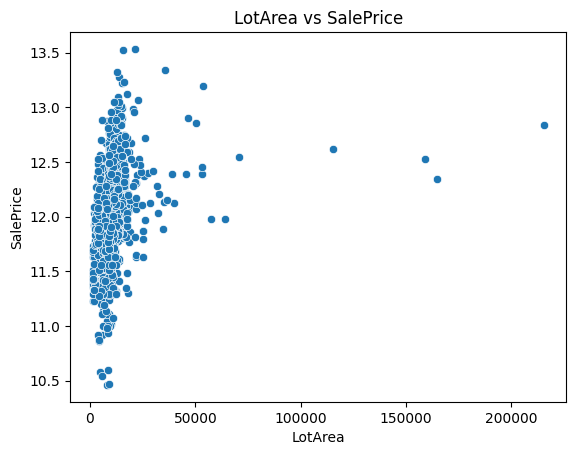

In [158]:
sns.scatterplot(x=trainData['LotArea'], y=trainData['SalePrice'])
plt.title("LotArea vs SalePrice")

trainData = trainData[trainData['GrLivArea'] < 4000]
trainData = trainData[trainData['LotArea'] < 7500]

### -- `Feature Engineering` -- 

In [159]:
trainData['TotalSF'] = trainData['1stFlrSF'] + trainData['2ndFlrSF'] + trainData['TotalBsmtSF']
trainData['Age'] = trainData['YrSold'] - trainData['YearBuilt']

#### &#10140; *Preparing Data*</br>

In [160]:
trainData.to_csv("processed_train_data.csv", index=False)

In [161]:
y = trainData['SalePrice']
X = trainData.drop('SalePrice', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=55)

In [162]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
import numpy as np

def rmsle(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)  
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

final_model = XGBRegressor(
    colsample_bytree=0.6,
    gamma=0,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    n_estimators=1000,
    reg_alpha=0.01,
    reg_lambda=2,
    subsample=0.6,
    random_state=42
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_valid)

score = rmsle(y_valid, y_pred)
print(f"RMSLE: {score:.6f}")

RMSLE: 0.101432


In [163]:
testData = pd.read_csv('./data/test.csv')
testData.drop(['Id'], axis=1, inplace=True)

for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond',
            'MasVnrType']:
    testData[col] = testData[col].fillna("None")
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
            'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'MasVnrArea']:
    testData[col] = testData[col].fillna(0)
testData["LotFrontage"] = testData.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
testData['Electrical'] = testData['Electrical'].fillna(testData['Electrical'].mode()[0])
testData['KitchenAbvGr'] = testData['KitchenAbvGr'].fillna(testData['KitchenAbvGr'].mode()[0])

cat_cols = testData.select_dtypes(include=["object"]).columns
for col in cat_cols:
    testData[col] = testData[col].fillna("None")
testData = pd.get_dummies(testData, columns=cat_cols)

X_test = testData.reindex(columns=X_train.columns, fill_value=0)
print("Test data shape: ", X_test.shape)
print("Sucssessfully prepared test data.")

Test data shape:  (1459, 304)
Sucssessfully prepared test data.


In [164]:
final_model.fit(X_train, y_train)

test_predictions = final_model.predict(X_test)

submission = pd.DataFrame({
    'Id': pd.read_csv('./data/test.csv')['Id'],
    'SalePrice': np.expm1(test_predictions)
})
submission.to_csv('./data/submission.csv', index=False)
print("Predictions saved to './data/submission.csv'")
print("Script completed successfully.")


Predictions saved to './data/submission.csv'
Script completed successfully.
